<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=550 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

<h2 style="text-align: center;"><b>Семинар 6. PyTorch. Создание и обучение нейронных сетей </b></h2>


# Обучение нейронной сети с использованием PyTorch

В этом блокноте мы создадим и обучим простую нейронную сеть с помощью PyTorch. Наша цель - показать основы фреймворка Torch и достичь простого понимания того, как выглядит решение разных задач с помощью нейронных сетей.

In [1]:
import torch  

In [2]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)



## Подготовка датасета

Здесь мы узнаем некоторые базовые функции и классы подготовки данных из **PyTorch** как:

- `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`
- dataset downloading api

Для начала мы определим нашу проблему. Здесь мы загружаем набор данных MNIST (с PyTorch API)

MNIST:
- 28x28 изображений из `0`, `1`, .. `9`
- каждый пиксель серый (float value in [0, 1))
- targets это целое значение в диапазоне [0, 9] (10 классов)
- объекты ($x_i$, $y_i$), где $x_i$ размера (1, 28, 28), $y_i$ это значение int

Для наших целей мы вытяним входные данные ($ x $), чтобы наши данные во время обучения имели формы:

- `x_batch` размера `(batch_size, 784)`
- `y_batch` размера `(batch_size)`



In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [4]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [5]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [17]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


Заметьте! Нам не нужно реализовывать batch loader самостоятельно. Давайте воспользуемся его реализацией в torch, которая называется `DataLoader` из `torch.utils.data`.

In [7]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [8]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Наконец, мы подготовили наши данные, поэтому теперь мы создадим некоторую модель для классификации изображений!

## Модель и обучение (of abnormal people)


Теперь посмотрим, как **torch** вычисляет функции градиента во время вычисления выражения. Используя метод `.backward ()` для выражени, **мы передаем граф вычисления градиента до листьев**, которые являются надежными для параметров нашей модели.

Таким образом, мы используем эти знания, чтобы найти оптимальные веса некоторой модели, которая представлена ​​некоторым выражением.

Предположем,
1. Мы хотим обучить линейную модель.
2. Для каждого класса мы используем собственные веса для вычисления `logits` (логитов).
3. Мы используем `softmax` на логитах для вероятностей каждого класса.
4. Обучайте партии с помощью `sgd`.

In [9]:
features = 784
classes = 10

In [10]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[ 0.0094, -0.0330, -0.0007,  ..., -0.0221, -0.0199,  0.0329],
        [ 0.0212, -0.0191,  0.0129,  ..., -0.0297, -0.0127, -0.0229],
        [ 0.0352,  0.0265, -0.0124,  ..., -0.0298,  0.0331,  0.0255],
        ...,
        [ 0.0183,  0.0025, -0.0039,  ..., -0.0117, -0.0346,  0.0312],
        [ 0.0128, -0.0131,  0.0114,  ...,  0.0185, -0.0033, -0.0061],
        [-0.0277, -0.0058, -0.0136,  ...,  0.0223,  0.0327,  0.0042]],
       requires_grad=True)

SGD цикл обучения

In [11]:
epochs = 3
lr=1e-2
history = []

In [12]:
import numpy as np
from torch.nn.functional import cross_entropy

#КРОСС-ЭНТРОПИЯ ЗДЕСЬ БЕРЁТСЯ ОТ ЛОГИТОВ, А НЕ ОТ ВЕРОЯТНОСТЕЙ!

In [18]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    
    # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.reshape(x_batch.shape[0], -1)
    # вычисляем функцию потерь (log loss, также известная как кросс-энтропия)
    logits = x_batch @ W
    probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)
    
    loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
    history.append(loss.item())

    # вычисляем градиенты
    loss.backward()

    # делаем шаг градиентного спуска
    grad = W.grad
    with torch.no_grad():
      W -= lr * grad
    W.grad.zero_()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.09273609519004822
2,	 loss: 0.08972559869289398
3,	 loss: 0.08724267780780792


И, конечно же, мы может построить график для loss (функции потерь) во время обучения.

In [19]:
import matplotlib.pyplot as plt

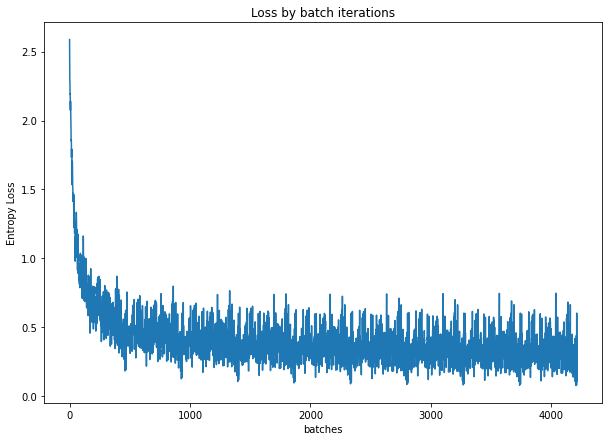

In [20]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

Посмотрим некоторые показатели качества для нашей линейной модели

In [21]:
from sklearn.metrics import accuracy_score

In [25]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # загружаем батч данных (вытянутый в линию)
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1)
  y_batch = y_batch

  preds = torch.argmax(x_batch @ W, dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.912


В результате теперь мы видим, что каждая переменная или тензор имеет свои собственные `grad` и `grad_fn`. Эта часть показала, что мы можем напрямую манипулировать ими. Также это очень неудобно, но иногда мы можем получить доступ к такой гибкости.

Конечно, PyTorch имеет более высокоуровневый способ работы с весами и градиентами, чем мы рассмотрели выше. В следующей части мы познакомимся с более высоким уровнем построения и обучения нейронных сетей. 


## Модель

PyTorch - это гибкий фреймворк для построения любой нейронной сети.

Вот таблица сравнения:

```
| API             | Flexibility | Convenience |,
|-----------------|-------------|-------------|,
| Barebone        | High        | Low         |,
| `nn.Module`     | High        | Medium      |,
| `nn.Sequential` | Low         | High        |
```

1. barebone - это подход, при котором мы напрямую манипулируем тернсорами. В приведенном выше примере у нас была целевая функция, напрямую выраженная весами. Если мы реализумем этот метод с использованием классов, мы получим API такого уровня: **На этом уровне мы сами кодируем модули**

2. [`nn.Module`] (https://pytorch.org/docs/stable/nn.html) - родительский класс для многих модулей, представленных PyTorch. Их много. Их достаточно, чтобы использовать их в готовом виде с необходимыми параметрами. В основном мы используем:

- `nn.Linear`
- `nn.Softmax`, `nn.LogSoftmax`
- `nn.ReLU`, `nn.ELU`, `nn.LeakyReLU`
- `nn.Tanh`, `nn.Sigmoid`
- `nn.LSTM`, `nn.GRU`
- `nn.Conv1d`, `nn.Conv2d`
- `nn.MaxPool1d`, `nn.AdaptiveMaxPool1d` and others pooling
- `nn.BatchNorm1d`, `nn.BatchNorm2d`
- `nn.Dropout`
- losses: `nn.CrossEntropyLoss`, `nn.NLLLoss`, `nn.MSELoss`
- etc


3. `nn.Sequential` - это не более чем последовательность различных модулей на основе` nn.Module`. Они инициируются списком модулей, где выходные данные одного модуля идут в качестве входных данных для следующего по порядку.


Давайте **разработаем простую последовательность** для классификацию MNIST с использованием **модели** двух линейных слоев и `nn.Sequential`.


In [29]:
import torch.nn as nn
from torchsummary import summary

In [31]:
model = nn.Sequential(
  nn.Linear(features, 64),
  nn.ReLU(),
  nn.Linear(64, classes)
  
  #НЕ НУЖНЕН СОФТМАКС
)

# It is the same as:
#
# model = nn.Sequential()
# model.add_module('0', nn.Linear(features, 64))
# model.add_module('1', nn.Linear(64, classes))

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

Проверить, все ли в порядке со скрытыми слоями, можно с помощью `torchsummary.summary`. Форма входных данных необходима для визуализации модели.

In [38]:
summary(model, (features,))

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: []

## Обучение

Как известно, при решении проблемы важны следующие **3 вещи**:

1. Модель
2. Цель (функция потерь / loss)
3. Оптимизация (для параметров модели)

Хорошо, все, что мы должны делать при использовании PyTorch, - это** определить следующие 3 вещи**:

1. Модель: из API `nn.Module`
2. Функция потерь (loss): опять же, `nn.Module` или [` nn.functional`] (https://pytorch.org/docs/stable/nn.functional.html) API.
3. Оптимизатор: основан на [`torch.optim.Optimizer`] (https://pytorch.org/docs/stable/optim.html).



В предыдущих задачах, когда дело доходило до оптимизации параметров, мы использовали **явное решения или градиентный спуск**

Конечно, есть множество улучшений градиентного спуска. Он может использовать **адаптивное значение шага**, **градиенты предыдущего шага** и другие. PyTorch также предоставляет несколько классов для оптимизации градиента. Они инициализируются с параметрами, которые они должны настроить для лучшего значения потерь, и во время спуска они делают шаг в методе спуска на основе градиента.

Вот наиболее часто используемые оптимизаторы, на основе которых используется алгоритм спуска:

- `torch.optim.Adam` использует как второй, так и первый импульс градиента, очень популярный благодаря своей скорости сходимости и простоте. [бумага] (https://arxiv.org/abs/1412.6980)

- `torch.optim.SGD` - старый добрый стохастический градиентный спуск. Может использоваться с оптимизацией импульса Нестерова

- `torch.optim.Adagrad` - [статья] (https://jmlr.org/papers/v12/duchi11a.html)

- `torch.optim.RMSprop` - введено в [слайды] (https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)


Сначала определим последние 2 вещи: критерий и оптимизатор.

In [26]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) в своей основе применительно к логитам (logits)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

Наконец, мы переходим в **циклу обучения**!

Ранее мы итерировались по эпохам и батчам (batch) (это называется обучающим циклом). Итак, давайте повторим это здесь

In [27]:
epochs = 3
history = []

In [28]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    # 1. # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
    logits = model(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
    loss = criterion(logits, y_batch)
    history.append(loss.item())

    # 4. вычисляем градиенты
    optimizer.zero_grad()
    loss.backward()

    # 5. шаг градиентного спуска
    optimizer.step()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.08913267403841019
2,	 loss: 0.06230849772691727
3,	 loss: 0.05196649953722954


построим график изменения точности просто для проверки правильности.

In [29]:
import matplotlib.pyplot as plt

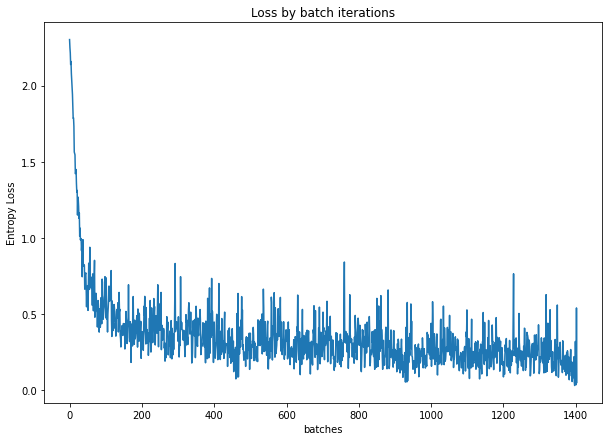

In [30]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

Некоторые метрики качества для нашей двух-слойной модели

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # загружаем батч данных (вытянутый в линию)
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)

  preds = torch.argmax(model(x_batch), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.937


## Резюмируем!

Мы построили и обучили простейшую нейронную сеть. Это было сделано путем определения:

1. `Модели`
2. "Критерия (Лосса)"
1. `Оптимизатора`

Запомните эти шаги, необходимые во время обучения одного батча данных:

1. загрузить батч
2. выполнить прямой проход модели (получить «логиты» / выходы модели)
3. рассчитать `loss` (используя критерий и «логиты» и истинные метки партии)
4. выполнить `loss.backward ()` (вычислить градиенты функции потери относительно параметров модели)
5. выполнить шаг оптимизации (`optimizer.step ()`)
* обнуляйте градиенты (производите в любой момент, но не между шагами 4 и 5)
* проверка (валидация) (после каждой эпохи)

